# RNN
This notebook based on [this tf tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#inspect_and_cleanup)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv('data_ML_19_05.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,close,close_change,open,high,low,volume,bb_bbh,bb_bbl,bb_bbm,ATR_10,...,ROCI_40,ROCI_60,ROCI_120,Vortex_diff,Vortex_neg,Vortex_pos,ichimoku_a,ichimoku_b,ichimoku_bl,ichimoku_cl
date,,,,,,,,,,,,,,,,,,,,,
2015-01-19,1.15947,1,1.190209,1.192707,1.183859,125293.70,1.224872,1.182937,1.203905,0.005052,...,0.000000,0.000000,0.000000,-0.292063,0.566607,0.274544,1.199552,1.202186,1.202186,1.196918
2015-06-08,1.12800,1,1.109748,1.115922,1.103201,178572.05,1.148248,1.085201,1.116725,0.011961,...,3.059706,3.102878,-6.589708,0.134893,0.930980,1.065874,1.113431,1.099360,1.111859,1.115003
2015-06-09,1.12926,1,1.108914,1.115403,1.102083,189387.35,1.147392,1.085082,1.116237,0.012098,...,2.952450,3.084663,-6.401610,0.114822,0.941023,1.055845,1.113217,1.099360,1.112258,1.114176
2015-06-10,1.13099,1,1.108156,1.115101,1.101890,191876.60,1.146536,1.084730,1.115633,0.012210,...,2.897022,3.109756,-6.191681,0.093968,0.952233,1.046201,1.113011,1.099360,1.112656,1.113366
2015-06-11,1.12458,0,1.108085,1.115129,1.102208,190246.55,1.145869,1.084101,1.114985,0.012281,...,2.946539,3.079194,-5.817274,0.076014,0.961502,1.037516,1.112856,1.099360,1.113054,1.112659


In [4]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
close,1861.0,1.137301,0.045937,1.039060,1.105430,1.128650,1.174750,1.251050e+00
close_change,1861.0,0.513165,0.499961,0.000000,0.000000,1.000000,1.000000,1.000000e+00
open,1861.0,1.136678,0.044869,1.046368,1.105618,1.125398,1.173848,1.238331e+00
high,1861.0,1.140281,0.044782,1.050833,1.108874,1.129695,1.177069,1.243405e+00
low,1861.0,1.133227,0.044962,1.042300,1.102606,1.122111,1.170567,1.233477e+00
volume,1861.0,247352.764938,177030.216417,70544.650000,157759.300000,196915.750000,255889.600000,1.033664e+06
bb_bbh,1861.0,1.151753,0.043913,1.063999,1.120490,1.142256,1.187622,1.253492e+00
bb_bbl,1861.0,1.120860,0.045657,1.033494,1.087066,1.112951,1.158872,1.223170e+00
bb_bbm,1861.0,1.136307,0.044377,1.049710,1.106093,1.125060,1.173060,1.236226e+00
ATR_10,1861.0,0.007145,0.001984,0.003465,0.006008,0.006848,0.008210,1.457193e-02


## Preparing the data

In [5]:
df.drop('close_change', axis=1, inplace=True)
target_column = 'close'
df.head()

,close,open,high,low,volume,bb_bbh,bb_bbl,bb_bbm,ATR_10,ATR_20,...,ROCI_40,ROCI_60,ROCI_120,Vortex_diff,Vortex_neg,Vortex_pos,ichimoku_a,ichimoku_b,ichimoku_bl,ichimoku_cl
date,,,,,,,,,,,,,,,,,,,,,
2015-01-19,1.15947,1.190209,1.192707,1.183859,125293.70,1.224872,1.182937,1.203905,0.005052,0.000893,...,0.000000,0.000000,0.000000,-0.292063,0.566607,0.274544,1.199552,1.202186,1.202186,1.196918
2015-06-08,1.12800,1.109748,1.115922,1.103201,178572.05,1.148248,1.085201,1.116725,0.011961,0.012032,...,3.059706,3.102878,-6.589708,0.134893,0.930980,1.065874,1.113431,1.099360,1.111859,1.115003
2015-06-09,1.12926,1.108914,1.115403,1.102083,189387.35,1.147392,1.085082,1.116237,0.012098,0.012096,...,2.952450,3.084663,-6.401610,0.114822,0.941023,1.055845,1.113217,1.099360,1.112258,1.114176
2015-06-10,1.13099,1.108156,1.115101,1.101890,191876.60,1.146536,1.084730,1.115633,0.012210,0.012152,...,2.897022,3.109756,-6.191681,0.093968,0.952233,1.046201,1.113011,1.099360,1.112656,1.113366
2015-06-11,1.12458,1.108085,1.115129,1.102208,190246.55,1.145869,1.084101,1.114985,0.012281,0.012191,...,2.946539,3.079194,-5.817274,0.076014,0.961502,1.037516,1.112856,1.099360,1.113054,1.112659


In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices

{'close': 0,
 'open': 1,
 'high': 2,
 'low': 3,
 'volume': 4,
 'bb_bbh': 5,
 'bb_bbl': 6,
 'bb_bbm': 7,
 'ATR_10': 8,
 'ATR_20': 9,
 'ATR_40': 10,
 'ATR_60': 11,
 'ATR_120': 12,
 'ROCI_10': 13,
 'ROCI_20': 14,
 'ROCI_40': 15,
 'ROCI_60': 16,
 'ROCI_120': 17,
 'Vortex_diff': 18,
 'Vortex_neg': 19,
 'Vortex_pos': 20,
 'ichimoku_a': 21,
 'ichimoku_b': 22,
 'ichimoku_bl': 23,
 'ichimoku_cl': 24}

In [7]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

normalizing

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

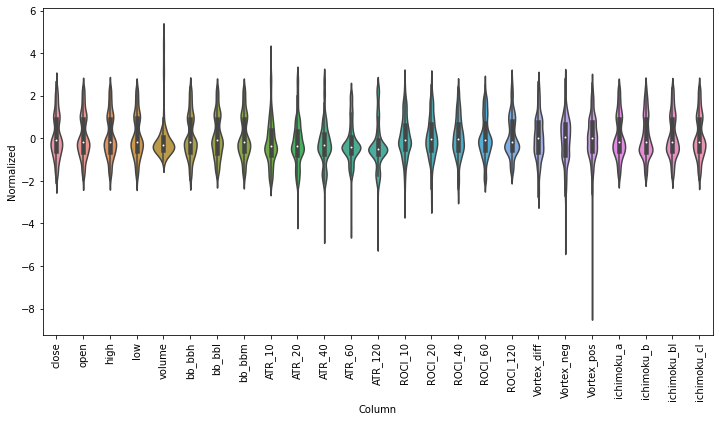

In [9]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Windows generation

In [10]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df,val_df=val_df, test_df=test_df,
                label_columns=None):
        
        #Storing raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [11]:
w1 = WindowGenerator(input_width=22, label_width=1, shift=24,
                     label_columns=[target_column])
w1

Total window size: 46
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Label indices: [45]
Label column name(s): ['close']

In [12]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=[target_column])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [13]:
w2.total_window_size

7

Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

In [14]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [15]:
WindowGenerator.split_window = split_window

In [16]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 25)
Inputs shape: (3, 6, 25)
labels shape: (3, 1, 1)


### plot

In [17]:
def plot(self, model=None, plot_col='close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [18]:
w2.example = example_inputs, example_labels

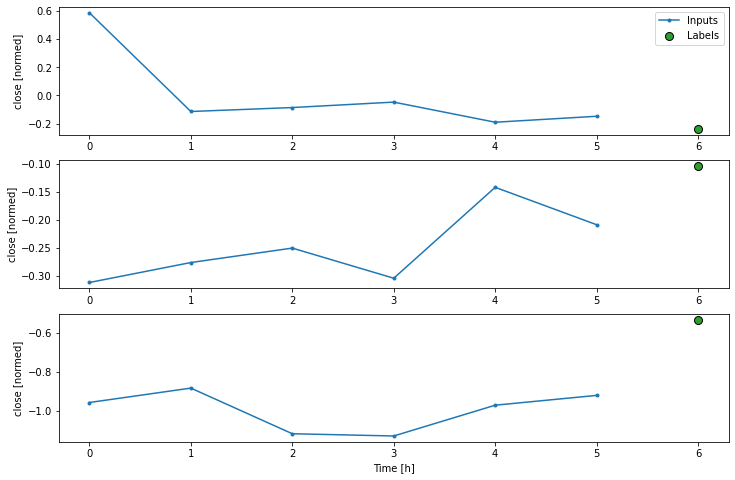

In [19]:
w2.plot()

In [20]:
#w2.plot(plot_col='ATR')


In [21]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [23]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 25), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [24]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 6, 25)
Labels shape (batch, time, features): (32, 1, 1)


# Single step models

In [25]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[target_column])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [26]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 25)
Labels shape (batch, time, features): (32, 1, 1)


In [27]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [28]:
'''
baseline = Baseline(label_index=column_indices[target_column])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
'''

"\nbaseline = Baseline(label_index=column_indices[target_column])\n\nbaseline.compile(loss=tf.losses.MeanSquaredError(),\n                 metrics=[tf.metrics.MeanAbsoluteError()])\n\nval_performance = {}\nperformance = {}\nval_performance['Baseline'] = baseline.evaluate(single_step_window.val)\nperformance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)\n"

In [29]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=[target_column])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [30]:
baseline = Baseline(label_index=column_indices[target_column])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


11/11 [==============================] - 0s 2ms/step - loss: 0.0099 - mean_absolute_error: 0.0704


In [31]:
#wide_window.example

In [32]:
print('Input shape:', wide_window.example[0].shape)
#baseline(wide_window.example[0]).shape
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 25)
Output shape: (32, 24, 1)


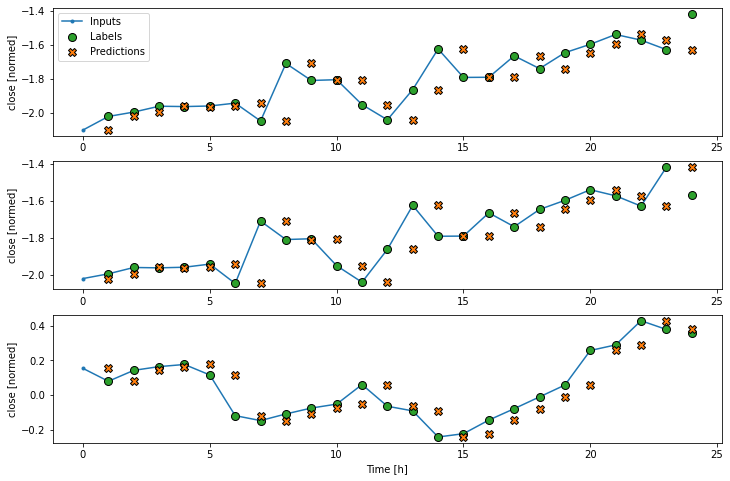

In [33]:
wide_window.plot(baseline)

## Linear model

In [34]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [35]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 25)
Output shape: (32, 1, 1)


In [36]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [37]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
41/41 [==============================] - 1s 6ms/step - loss: 1.0317 - mean_absolute_error: 0.8185 - val_loss: 0.4901 - val_mean_absolute_error: 0.5022
Epoch 2/20
41/41 [==============================] - 0s 3ms/step - loss: 0.4432 - mean_absolute_error: 0.5231 - val_loss: 0.3451 - val_mean_absolute_error: 0.4493
Epoch 3/20
41/41 [==============================] - 0s 3ms/step - loss: 0.2702 - mean_absolute_error: 0.4058 - val_loss: 0.2955 - val_mean_absolute_error: 0.4145
Epoch 4/20
41/41 [==============================] - 0s 3ms/step - loss: 0.2116 - mean_absolute_error: 0.3575 - val_loss: 0.2652 - val_mean_absolute_error: 0.3919
Epoch 5/20
41/41 [==============================] - 0s 3ms/step - loss: 0.1789 - mean_absolute_error: 0.3269 - val_loss: 0.2416 - val_mean_absolute_error: 0.3753
Epoch 6/20
41/41 [==============================] - 0s 3ms/step - loss: 0.1566 - mean_absolute_error: 0.3066 - val_loss: 0.2207 - val_mean_absolute_error: 0.3583
Epoch 7/20
41/41 [==========

In [38]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
#performance['Linear']

Input shape: (32, 24, 25)
Output shape: (32, 24, 1)


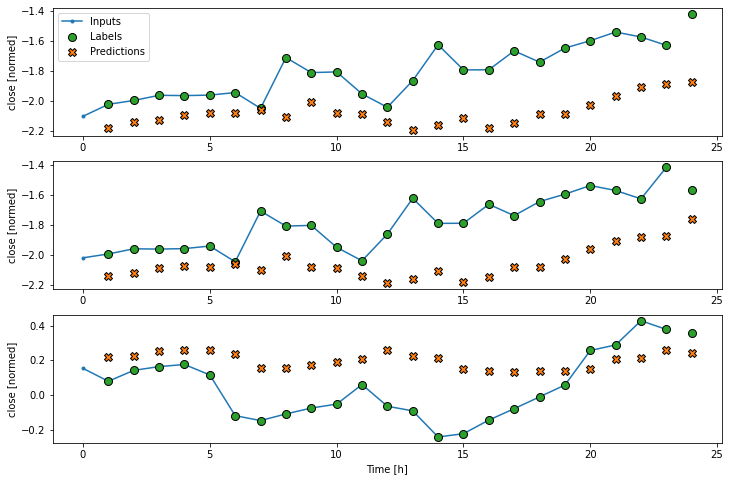

In [39]:
wide_window.plot(linear)


In [40]:
val_performance['Linear']

[0.07439813017845154, 0.2067113071680069]

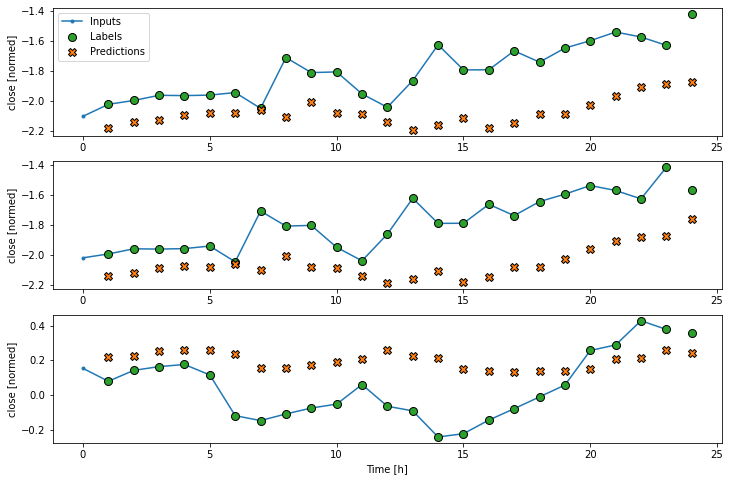

In [41]:
wide_window.plot(linear)

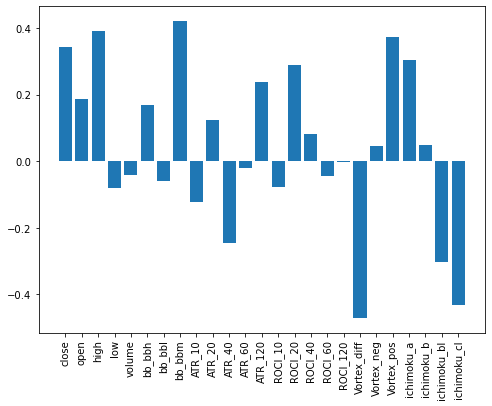

In [42]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


## Dense

In [43]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
41/41 [==============================] - 1s 7ms/step - loss: 0.2278 - mean_absolute_error: 0.3043 - val_loss: 0.0718 - val_mean_absolute_error: 0.1916
Epoch 2/20
41/41 [==============================] - 0s 3ms/step - loss: 0.0408 - mean_absolute_error: 0.1576 - val_loss: 0.0763 - val_mean_absolute_error: 0.2123
Epoch 3/20
12/12 [==============================] - 0s 1ms/step - loss: 0.0769 - mean_absolute_error: 0.2159


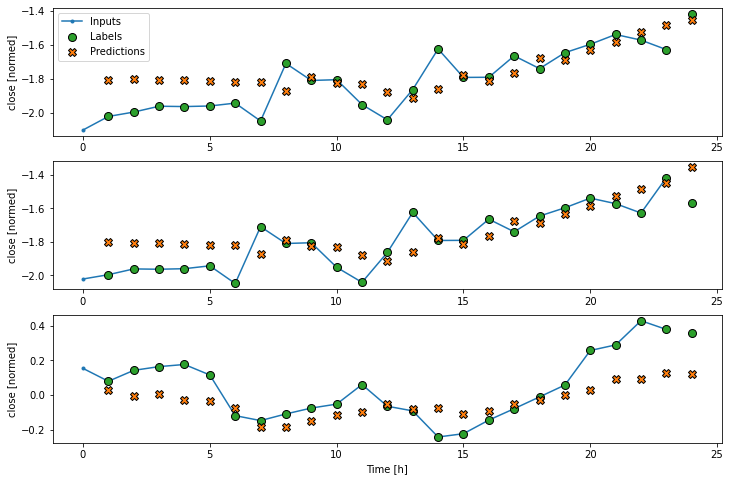

In [44]:
wide_window.plot(dense)

## RNN

In [45]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
#print('Output shape:', lstm_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 24, 25)


In [46]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128),
    #tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [47]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 24, 25)
Output shape: (32, 1)


In [48]:

history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


Epoch 1/20
40/40 [==============================] - 4s 36ms/step - loss: 0.1476 - mean_absolute_error: 0.2609 - val_loss: 0.0562 - val_mean_absolute_error: 0.1704
Epoch 2/20
40/40 [==============================] - 1s 25ms/step - loss: 0.0446 - mean_absolute_error: 0.1636 - val_loss: 0.0561 - val_mean_absolute_error: 0.1704
Epoch 3/20
40/40 [==============================] - 1s 25ms/step - loss: 0.0430 - mean_absolute_error: 0.1603 - val_loss: 0.0542 - val_mean_absolute_error: 0.1664
Epoch 4/20
40/40 [==============================] - 1s 26ms/step - loss: 0.0428 - mean_absolute_error: 0.1598 - val_loss: 0.0539 - val_mean_absolute_error: 0.1658
Epoch 5/20
40/40 [==============================] - 1s 25ms/step - loss: 0.0427 - mean_absolute_error: 0.1594 - val_loss: 0.0534 - val_mean_absolute_error: 0.1647
Epoch 6/20
40/40 [==============================] - 1s 25ms/step - loss: 0.0426 - mean_absolute_error: 0.1593 - val_loss: 0.0524 - val_mean_absolute_error: 0.1625
Epoch 7/20
40/40 [====

In [ ]:
#wide_window.plot(lstm_model)


## Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

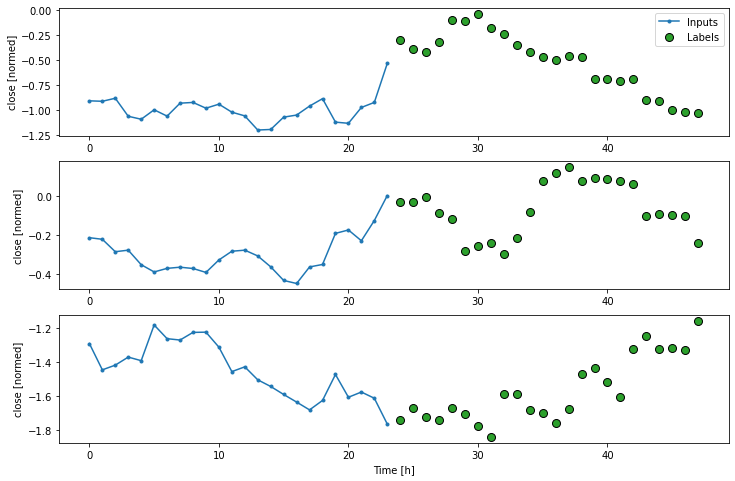

In [50]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

11/11 [==============================] - 0s 0s/step - loss: 0.3492 - mean_absolute_error: 0.3281


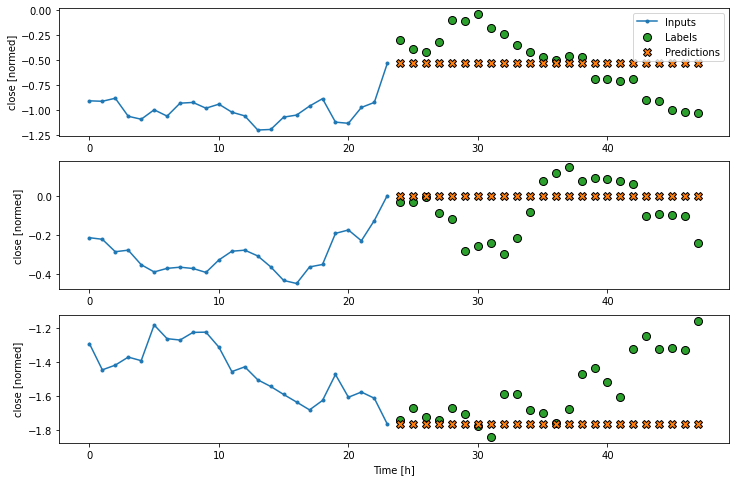

In [51]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


11/11 [==============================] - 0s 1ms/step - loss: 0.7228 - mean_absolute_error: 0.5343


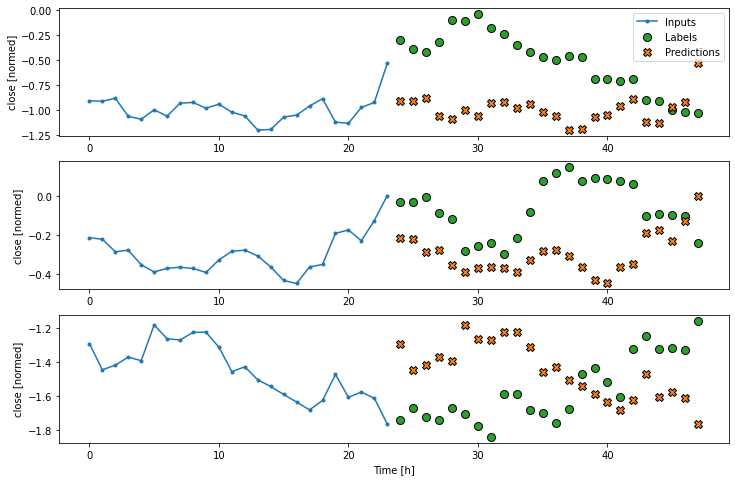

In [52]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)


## Lineral

Epoch 1/20
40/40 [==============================] - 1s 5ms/step - loss: 0.7041 - mean_absolute_error: 0.6401 - val_loss: 0.7497 - val_mean_absolute_error: 0.6824
Epoch 2/20
40/40 [==============================] - 0s 3ms/step - loss: 0.3849 - mean_absolute_error: 0.4577 - val_loss: 0.5634 - val_mean_absolute_error: 0.5671
Epoch 3/20
40/40 [==============================] - 0s 3ms/step - loss: 0.2643 - mean_absolute_error: 0.3587 - val_loss: 0.4543 - val_mean_absolute_error: 0.4874
Epoch 4/20
40/40 [==============================] - 0s 3ms/step - loss: 0.2164 - mean_absolute_error: 0.3095 - val_loss: 0.3948 - val_mean_absolute_error: 0.4364
Epoch 5/20
40/40 [==============================] - 0s 3ms/step - loss: 0.1927 - mean_absolute_error: 0.2835 - val_loss: 0.3610 - val_mean_absolute_error: 0.4033
Epoch 6/20
40/40 [==============================] - 0s 3ms/step - loss: 0.1782 - mean_absolute_error: 0.2675 - val_loss: 0.3421 - val_mean_absolute_error: 0.3824
Epoch 7/20
40/40 [==========

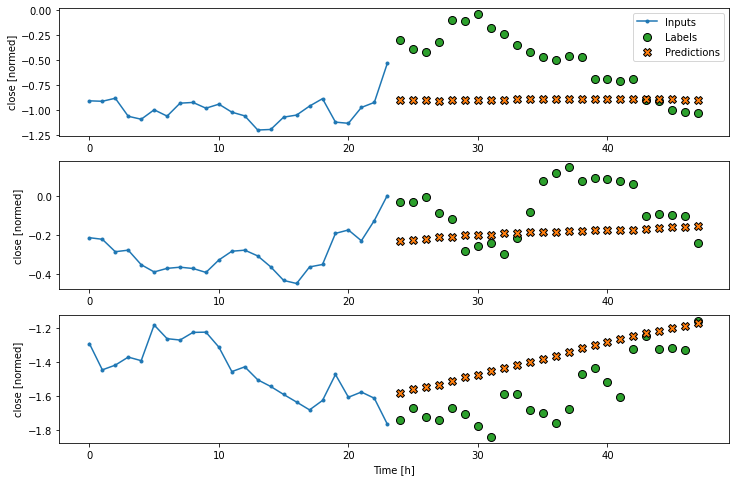

In [53]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

#IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)


Epoch 1/20
40/40 [==============================] - 1s 10ms/step - loss: 0.3366 - mean_absolute_error: 0.3972 - val_loss: 0.3327 - val_mean_absolute_error: 0.3561
Epoch 2/20
40/40 [==============================] - 0s 7ms/step - loss: 0.1271 - mean_absolute_error: 0.2234 - val_loss: 0.2771 - val_mean_absolute_error: 0.3047
Epoch 3/20
40/40 [==============================] - 0s 7ms/step - loss: 0.0966 - mean_absolute_error: 0.1892 - val_loss: 0.2504 - val_mean_absolute_error: 0.2819
Epoch 4/20
40/40 [==============================] - 0s 7ms/step - loss: 0.0819 - mean_absolute_error: 0.1718 - val_loss: 0.2413 - val_mean_absolute_error: 0.2804
Epoch 5/20
40/40 [==============================] - 0s 7ms/step - loss: 0.0709 - mean_absolute_error: 0.1597 - val_loss: 0.2385 - val_mean_absolute_error: 0.2800
Epoch 6/20
40/40 [==============================] - 0s 7ms/step - loss: 0.0613 - mean_absolute_error: 0.1480 - val_loss: 0.2492 - val_mean_absolute_error: 0.2880
Epoch 7/20
11/11 [=========

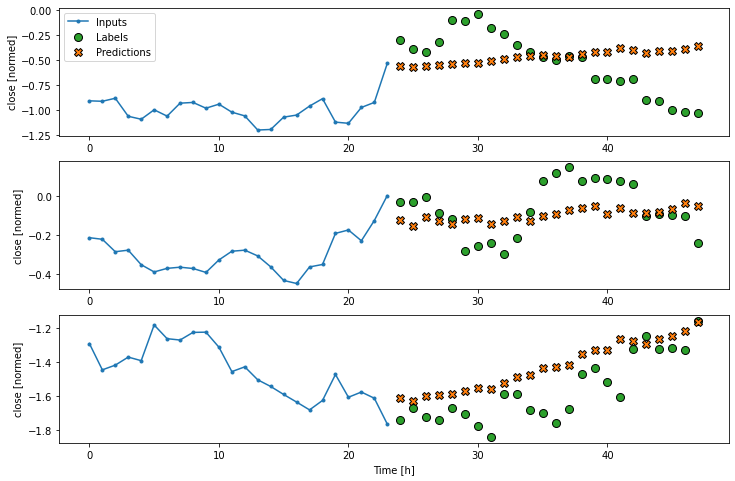

In [54]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

#IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)


# CNN

Epoch 1/20
40/40 [==============================] - 1s 8ms/step - loss: 0.3793 - mean_absolute_error: 0.4217 - val_loss: 0.3628 - val_mean_absolute_error: 0.3689
Epoch 2/20
40/40 [==============================] - 0s 5ms/step - loss: 0.1480 - mean_absolute_error: 0.2441 - val_loss: 0.3069 - val_mean_absolute_error: 0.3225
Epoch 3/20
40/40 [==============================] - 0s 5ms/step - loss: 0.1083 - mean_absolute_error: 0.2043 - val_loss: 0.2771 - val_mean_absolute_error: 0.2985
Epoch 4/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0895 - mean_absolute_error: 0.1834 - val_loss: 0.2635 - val_mean_absolute_error: 0.2973
Epoch 5/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0749 - mean_absolute_error: 0.1667 - val_loss: 0.2630 - val_mean_absolute_error: 0.3003
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0640 - mean_absolute_error: 0.1540 - val_loss: 0.2667 - val_mean_absolute_error: 0.3065
Epoch 7/20
11/11 [==========

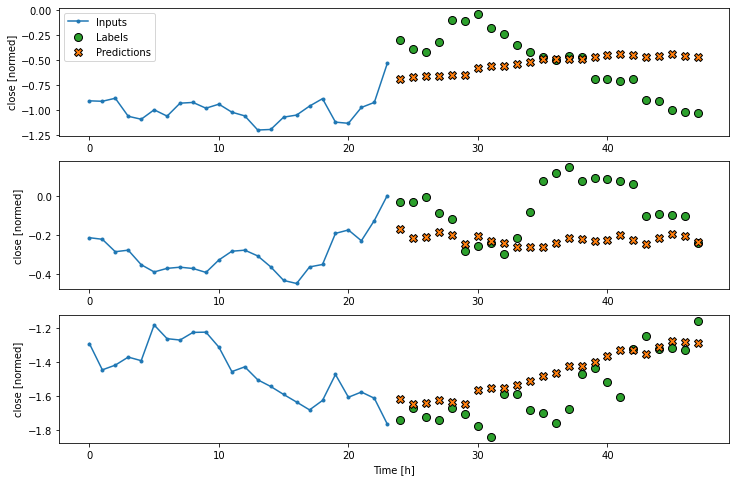

In [55]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

#IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


# RNN

Epoch 1/20
40/40 [==============================] - 3s 22ms/step - loss: 0.7824 - mean_absolute_error: 0.6679 - val_loss: 0.8157 - val_mean_absolute_error: 0.6909
Epoch 2/20
40/40 [==============================] - 0s 12ms/step - loss: 0.4810 - mean_absolute_error: 0.5053 - val_loss: 0.6502 - val_mean_absolute_error: 0.6224
Epoch 3/20
40/40 [==============================] - 0s 11ms/step - loss: 0.3277 - mean_absolute_error: 0.4068 - val_loss: 0.5202 - val_mean_absolute_error: 0.5376
Epoch 4/20
40/40 [==============================] - 0s 11ms/step - loss: 0.2391 - mean_absolute_error: 0.3365 - val_loss: 0.4608 - val_mean_absolute_error: 0.4937
Epoch 5/20
40/40 [==============================] - 0s 11ms/step - loss: 0.1846 - mean_absolute_error: 0.2883 - val_loss: 0.4142 - val_mean_absolute_error: 0.4577
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 0.1441 - mean_absolute_error: 0.2504 - val_loss: 0.3863 - val_mean_absolute_error: 0.4361
Epoch 7/20
40/40 [====

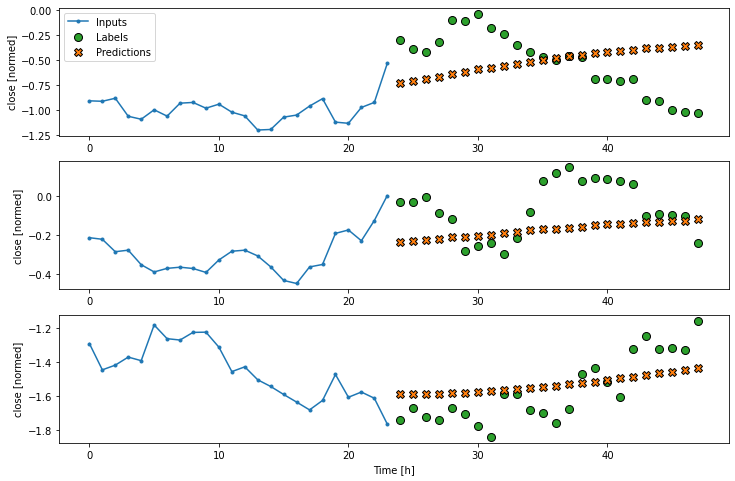

In [56]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

#IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


# ADV

In [57]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)


In [58]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [59]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [60]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 25])

In [61]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [62]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 25)


Epoch 1/20
40/40 [==============================] - 7s 36ms/step - loss: 0.7741 - mean_absolute_error: 0.6658 - val_loss: 0.7091 - val_mean_absolute_error: 0.6424
Epoch 2/20
40/40 [==============================] - 1s 17ms/step - loss: 0.4567 - mean_absolute_error: 0.4958 - val_loss: 0.5209 - val_mean_absolute_error: 0.5349
Epoch 3/20
40/40 [==============================] - 1s 17ms/step - loss: 0.3193 - mean_absolute_error: 0.4121 - val_loss: 0.5003 - val_mean_absolute_error: 0.5230
Epoch 4/20
40/40 [==============================] - 1s 17ms/step - loss: 0.2599 - mean_absolute_error: 0.3678 - val_loss: 0.5001 - val_mean_absolute_error: 0.5350
Epoch 5/20
40/40 [==============================] - 1s 17ms/step - loss: 0.2170 - mean_absolute_error: 0.3336 - val_loss: 0.5211 - val_mean_absolute_error: 0.5289
Epoch 6/20
11/11 [==============================] - 0s 5ms/step - loss: 0.5148 - mean_absolute_error: 0.5222


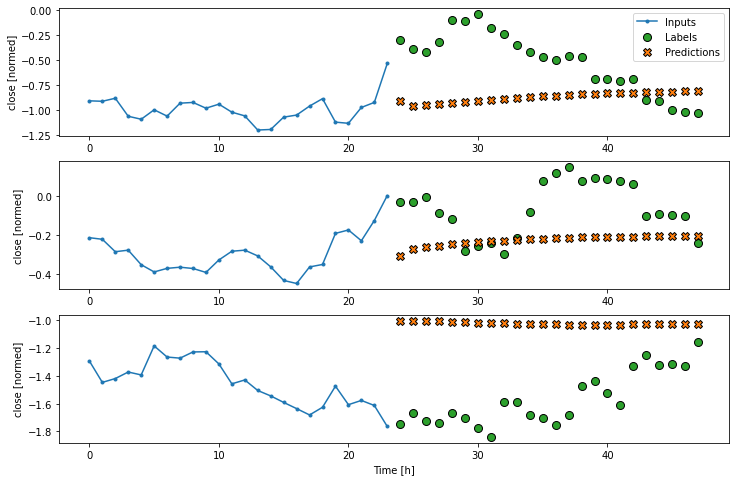

In [63]:
history = compile_and_fit(feedback_model, multi_window)

#IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)


In [64]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [65]:
paper_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(24, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(20, return_sequences=False),
    tf.keras.layers.BatchNormalization(),

    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

#IPython.display.clear_output()

paper_val_performance['LSTM'] = paper_lstm_model.evaluate(multi_window.val)
paper_performance['LSTM'] = paper_lstm_model.evaluate(multi_window.test, verbose=0)
paper_window.plot(paper_lstm_model)

Epoch 1/20
40/40 [==============================] - 3s 22ms/step - loss: 0.0564 - mean_absolute_error: 0.1584 - val_loss: 0.3981 - val_mean_absolute_error: 0.4587
Epoch 2/20
40/40 [==============================] - 0s 11ms/step - loss: 0.0473 - mean_absolute_error: 0.1441 - val_loss: 0.3975 - val_mean_absolute_error: 0.4566
Epoch 3/20
40/40 [==============================] - 0s 11ms/step - loss: 0.0414 - mean_absolute_error: 0.1346 - val_loss: 0.3900 - val_mean_absolute_error: 0.4529
Epoch 4/20
40/40 [==============================] - 0s 11ms/step - loss: 0.0363 - mean_absolute_error: 0.1257 - val_loss: 0.3869 - val_mean_absolute_error: 0.4484
Epoch 5/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0328 - mean_absolute_error: 0.1189 - val_loss: 0.3765 - val_mean_absolute_error: 0.4415
Epoch 6/20
40/40 [==============================] - 0s 12ms/step - loss: 0.0303 - mean_absolute_error: 0.1142 - val_loss: 0.3713 - val_mean_absolute_error: 0.4346
Epoch 7/20
40/40 [====

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.